<h1> pyNEST</h1> <h1> generate Nph,Ne and S1,S2 from and Energy array. for LZ </h1>

In [37]:
from __future__ import division
import pylab
import scipy.interpolate as ip
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data') #frozen with NEST v98
from aLib import pyNEST as pn
from aLib import inrange
from aLib import eff
from aLib import rates
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import scipy.stats as st
import numpy as np
import scipy.io as sio
%pylab inline  
#always do this for plotting...  don't ask why
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Define function Energy_array->quanta->signal, for LZ </h1>

In [38]:
def E2NphNe(ParticleType='ER',Energy = linspace(1,100,1000),f_drift=700,g1=0.075,SPE_res= 0.5,eff_extract=0.95,SE_size=50,SE_res=sqrt(50),e_lifetime=1000, dt0=500):
    #input: ParticleType('ER' or 'NR'), Energy array, drift field V/cm, g1, SPE_res, electron extraction efficiency, SE size, sigSE, electron lifetime, center of detector)
    Nph, Ne = pn.Nph_Ne(ParticleType,f_drift*np.ones_like(Energy),Energy)
    S1 = st.binom.rvs(array(Nph, dtype=int64),g1) #mod g1
    #No S1 PMT resolution, assume spike counting
    #add PMT resolution, assume sigma = 0.5 PE for a single PE collected
    #S1_B8 = st.norm.rvs(S1_B8,sqrt(S1_B8)*SPE_res,size=size(S1_B8)) #single PE resolution with sigma=sqrt(N)*sig
    Ne_ext = st.binom.rvs(array(Ne*exp(-dt0/e_lifetime), dtype=int64), eff_extract) #add in mean electron attenuation
    S2 = st.norm.rvs(Ne_ext*SE_size,sqrt(SE_res**2 * Ne_ext),size=size(Ne_ext)) #adding variance "SE_res**2 * Ne_ext"
    S2 = S2*exp(dt0/e_lifetime) #correct back the electron lifetime
    
    return Nph, Ne, S1, S2

<h1> Define function to generate flat ER and NR bands </h1>

In [42]:
def genBands(nSim=1e5,maxS1=50,f_drift=700,g1=0.075,SPE_res= 0.5,eff_extract=0.95,SE_size=50,SE_res=sqrt(50),e_lifetime=1000, dt0=500):
    #Calculate the NR band, and count below that for acceptance ########
    maxEr=100 #keVnr, for flat spectrum... DD
    Flat_Er = maxEr*st.uniform.rvs(size=nSim); #0-100 keVnr
    Nph_flat, Ne_flat= pn.Nph_Ne('NR',f_drift*np.ones_like(Flat_Er),Flat_Er)
    S1_flat = st.binom.rvs(array(Nph_flat, dtype=int64),g1) #mod g1 with spe
    Ne_flat_ext = st.binom.rvs(array(Ne_flat*exp(-dt0/e_lifetime), dtype=int64), eff_extract)
    S2_flat = st.norm.rvs(Ne_flat_ext*SE_size,sqrt(SE_res**2 * Ne_flat_ext),size=size(Ne_flat_ext))
    S2_flat = S2_flat*exp(dt0/e_lifetime)
    S1_bins=linspace(1,maxS1,maxS1)
    mean_S2oS1_flat_n=empty_like(S1_bins)
    #Find the NR S2/S1 band at each S1
    for index, S1s in enumerate(S1_bins):
        mean_S2oS1_flat_n[index]=mean(S2_flat[S1_flat==S1s]/S1s)
        
    #Calculate the ER band #################################
    maxEe=100 #keVee, for flat ER spectrum
    Flat_Ee = maxEe*st.uniform.rvs(size=nSim); #0-100 keVee
    Nph_flat_e, Ne_flat_e= pn.Nph_Ne('ER',f_drift*np.ones_like(Flat_Ee),Flat_Ee)
    S1_e = st.binom.rvs(array(Nph_flat_e, dtype=int64),g1) #mod g1 with spe
    Ne_e_ext = st.binom.rvs(array(Ne_flat_e*exp(-dt0/e_lifetime), dtype=int64), eff_extract)
    S2_e = st.norm.rvs(Ne_e_ext*SE_size,sqrt(SE_res**2 * Ne_e_ext),size=size(Ne_e_ext))
    S2_e_c = S2_e*exp(dt0/e_lifetime)
    S1_bins=linspace(1,maxS1,maxS1)
    mean_S2oS1_e=empty_like(S1_bins)
    stdev_S2oS1_e=empty_like(S1_bins)
    #Find the ER S2/S1 band at each S1
    for index, S1s in enumerate(S1_bins):
        s1_cut=[(S1_e==S1s) & (S2_e_c>0)]
        mean_S2oS1_e[index]=mean(log10(S2_e_c[s1_cut]/S1s))
        stdev_S2oS1_e[index]=std(log10(S2_e_c[s1_cut]/S1s))
   
    return S1_bins, mean_S2oS1_flat_n, mean_S2oS1_e, stdev_S2oS1_e

In [39]:
def scatterColor(x,y,a=0.8):
    xy=vstack([x,y])
    xy[isnan(xy)]=0
    xy[isinf(xy)]=0
    z= st.gaussian_kde(xy)(xy)
    scatter(x,y,c=z,s=8,edgecolor='',alpha=a)
    return

<h1> now run the code on an arbitrary csv or mat file </h1>

In [ ]:
#Load from CSV
#data=loadtxt('../Analysis_Code/Run03_Golden_Doke/fits/s2_and_s1_means.txt') 

#Load from matfile
#data=sio.loadmat('/project/projectdirs/lux/data/golden/Run03_Golden_numpy.mat')

<h1> now run the code with an energy array as the input </h1>

In [44]:
#Generate Flat ER and NR spectra:
S1_bins, mean_S2oS1_flat_n, mean_S2oS1_e, stdev_S2oS1_e = genBands()

#convert energy array into signal
Nph, Ne, S1, S2 = E2NphNe()

//global/project/projectdirs/lux/data/aLib/pyNEST.py:387: RuntimeWarning: invalid value encountered in true_divide
  R[TIB>0]       = 1. - np.log(1. + (Ni[TIB>0]/4.) * TIB[TIB>0]) / ((Ni[TIB>0]/4.)*TIB[TIB>0])
//global/project/projectdirs/lux/data/aLib/pyNEST.py:388: RuntimeWarning: invalid value encountered in greater
  R[R>1.]        = 1.
//global/project/projectdirs/lux/data/aLib/pyNEST.py:389: RuntimeWarning: invalid value encountered in less
  R[R<0.]        = 0.
//global/project/projectdirs/lux/data/aLib/pyNEST.py:111: RuntimeWarning: invalid value encountered in less
  poisMeanIn[poisMeanIn<1e-6] = 1e-6


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from IPython.kernel.zmq import kernelapp as app


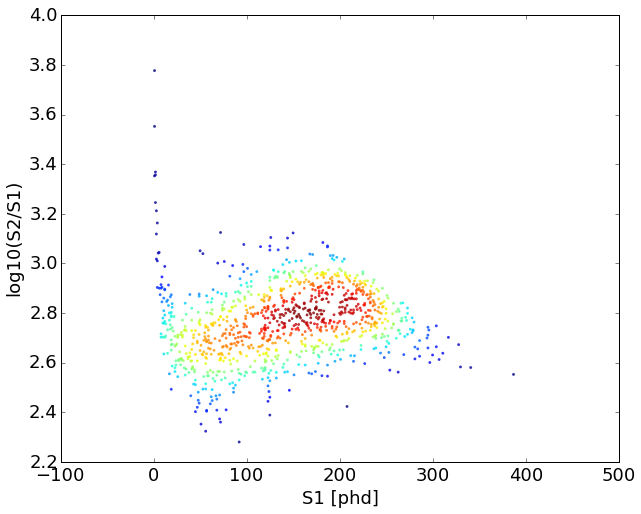

In [41]:
#make a scatter plot
scatterColor(S1,log10(S2/S1))
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
plt.rcParams.update({'font.size': 18})

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


(0, 50)

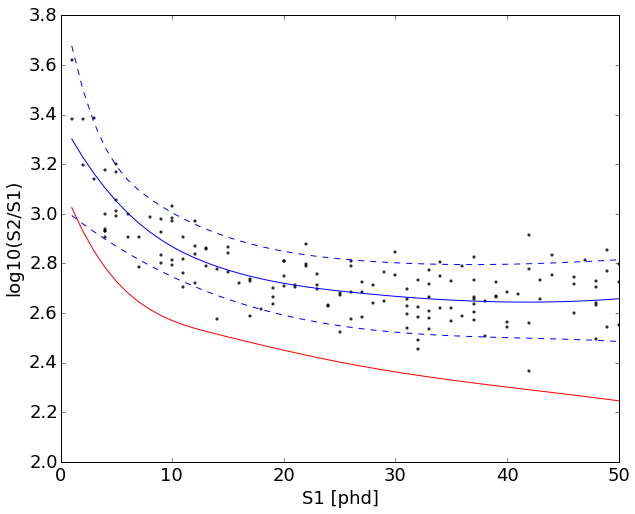

In [45]:
#plot WS region

plt.scatter(S1,log10(S2/S1),c='black',s=5,alpha=0.7)
plt.xlabel('S1 [phd]')
plt.ylabel('log10(S2/S1)')
plt.rcParams.update({'font.size': 18})

#plot NR mean, with a smooth spline
s = ip.UnivariateSpline(S1_bins, log10(mean_S2oS1_flat_n), s=.005)
plot(S1_bins,s(S1_bins),'-r')

#plot ER means, with a smooth spline
s = ip.UnivariateSpline(S1_bins, mean_S2oS1_e, s=.005)
s_ub = ip.UnivariateSpline(S1_bins, mean_S2oS1_e+1.28*stdev_S2oS1_e, s=.005) #1.28 sigma for 10-90% bands
s_lb = ip.UnivariateSpline(S1_bins, mean_S2oS1_e-1.28*stdev_S2oS1_e, s=.005)
plot(S1_bins,s(S1_bins),'-b')
plot(S1_bins,s_ub(S1_bins),'--b')
plot(S1_bins,s_lb(S1_bins),'--b')

xlim([0,50])

<h1> Save the data </h1>

In [ ]:
#savetxt(filename,data)